# How will future flood likelihood compare to present day's?

- In light of intensifying precipitation due to climate change, how will it change the likelihood of flood compare to present day?
- How will the frequency of flood change?

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import importlib
import os
import matplotlib.pyplot as plt
# import pymc as pm
# import pytensor.tensor as at
# import arviz as az
# from scipy.stats.mstats import mquantiles
import pickle
import re
from helper_functions import flood_utils, utils
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Import future projected data

In [5]:
def get_v3_ppt_percentiles(fp, percentiles = [50, 75, 90, 95, 99]):
    """ extracts extreme rainfall values for future ssp and model scenarios
    Args:
        fp (str): filepath to the hourly ppt V3 data
        percentiles (list or np.array): percentile values to extract from
    Returns:
        dict: returns the 50, 75, 90, 95, 99th percentile of V3 rainfall events for each ssp scenario and model
    """

    pr_df = pd.read_csv(fp) # units are kg m-2 s-1, aka mm/s, to conver to mm/hr, multiply by 3600
    # drop columns with the modelled historical data (1995 - 2014)
    columns_to_drop = [c for c in pr_df.columns.to_list() if bool(re.search('1995-2014', c))]
    pr_df = pr_df.drop(columns_to_drop, axis=1)
    # modelled ssp scenarios
    ssp_models_columns = pr_df.columns.to_list()[1:]

    return pr_df[pr_df['percentile'].isin(percentiles)][ssp_models_columns].to_dict()

v3_ppt_percentiles = get_v3_ppt_percentiles(fp = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\V3_extracted_data\percentile_pr_day.csv")
v3_ppt_percentiles

{'ACCESS-CM2_ssp126_2040-2059': {50: 0.8339650928974152,
  75: 6.591456055641174,
  90: 19.94506416320801,
  95: 31.98760051727294,
  99: 63.77194122314448},
 'ACCESS-CM2_ssp126_2080-2099': {50: 0.9059764742851256,
  75: 7.271434783935547,
  90: 21.52567024230958,
  95: 33.98128490447998,
  99: 66.37278984069823},
 'ACCESS-CM2_ssp245_2040-2059': {50: 0.843074381351471,
  75: 6.613412857055664,
  90: 20.14952869415283,
  95: 32.12863731384274,
  99: 63.017046966552726},
 'ACCESS-CM2_ssp245_2080-2099': {50: 0.5604923367500305,
  75: 5.78485119342804,
  90: 19.503822708129885,
  95: 31.984800720214807,
  99: 64.56634284973143},
 'ACCESS-CM2_ssp585_2040-2059': {50: 0.7176523506641388,
  75: 6.470632672309876,
  90: 19.661868667602548,
  95: 31.225192070007264,
  99: 61.29448234558094},
 'ACCESS-CM2_ssp585_2080-2099': {50: 0.1196856833994388,
  75: 4.08363676071167,
  90: 18.17029533386232,
  95: 32.11116313934312,
  99: 69.07949249267577},
 'EC-Earth3_ssp126_2040-2059': {50: 0.953174591064

# Import flood occurences

In [2]:
imported_data_dir = os.path.join(os.getcwd(),"Exported_Data")
flood_df = pd.read_csv(os.path.join(imported_data_dir,"precipitation_levels_during_flood_events.csv"))
flood_df
rf_types = [i for i in flood_df.columns.to_list() if i.startswith('highest')]
rf_types

['highest 30 min rainfall (mm)',
 'highest 60 min rainfall (mm)',
 'highest 120 min rainfall (mm)']

# Import drainage map
- plot spatial vulnerability of flood using drainage map

In [3]:
drainage_catchments = list(flood_utils.grid_code_drainage_catchment().values())
drainage_catchments

['Jurong',
 'Kranji',
 'Pandan',
 'Woodlands',
 'Kallang',
 'Bukit Timah',
 'Stamford Marina',
 'Singapore River',
 'Punggol',
 'Geylang',
 'Changi']

# Historical data

- max 30 min
- max 60 min
- max 120 min

## Plot probability of floods given historical percentiles of rainfall

### Plot distribution of probability

In [5]:
def get_historical_ppt_percentiles(fp, 
                                   rf_types = ['highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)'],percentiles = [50, 75, 90, 95, 99]):
    """ returns a extreme rainfall values for max 30, 60, 120 mins
    Args:
        fp (str): filepath to the historical weather csv
        rf_types (list of str): type of ppt e.g. max 30mins, max 60mins
        percentiles (list or np.array): percentile values to extract from
    Returns:
        dict: returns the 50, 75, 90, 95, 99th percentile of historical rainfall events for each rainfall type
    """
    weather_df1 = pd.read_csv(fp)
    historical_ppt_percentiles = dict()
    for rf_type in rf_types:
        x = weather_df1[rf_type].values
        x = x[~np.isnan(x)]
        p = np.percentile(x, percentiles) # CCRS deems extreme ppt at 95th and 99th percentile
        historical_ppt_percentiles[rf_type] = p
    return historical_ppt_percentiles

# historical_ppt_percentiles = get_historical_ppt_percentiles(fp = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\Exported_Data\historical_weather.csv")
def get_spatial_flood_baseline(fp,
                               rf_types = ['highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)'],
                               percentiles=[50, 75, 90, 95, 99]):
    
    """ returns the flooding probability for each drainage basin at each percentile of rainfall type
    Args:
        fp (str): filepath to historical_weather.csv
        rf_types (list of str): type of ppt e.g. max 30mins, max 60mins
        percentiles (np.array or list): percentiles to extract ppt values from
    Returns:
        dict: expected probability of flood at a given percentile across different drainage_catchment
    """
    historical_ppt_percentiles = get_historical_ppt_percentiles(fp, percentiles = percentiles,rf_types=rf_types)
    drainage_catchments = list(flood_utils.grid_code_drainage_catchment().values())
    # plot params
    nrows = len(drainage_catchments)
    ncols = len(rf_types)
    # dict to store expected probabilities
    # p_t_dict = {drainage_name: {rf: None} for drainage_name in drainage_catchments for rf in rf_types}
    p_t_dict = {drainage_name: dict() for drainage_name in drainage_catchments}
    # plot
    fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4,nrows*2))
    for row_idx, drainage_name in enumerate(drainage_catchments):
        for col_idx, rf in enumerate(rf_types):
            alpha_fp = os.path.join(os.getcwd(),"Exported_Data",f'alpha_{drainage_name} ({rf}).pkl')
            beta_fp = os.path.join(os.getcwd(),"Exported_Data",f'beta_{drainage_name} ({rf}).pkl')
            alpha = utils.load_pickle(alpha_fp) # distribution of alpha
            beta = utils.load_pickle(beta_fp) # distribution of beta
            percentile_array = historical_ppt_percentiles[rf][:, None] # values from percentile 50, 75, 90, 95, 99
            p_t = utils.logistic(percentile_array.T,beta,alpha)
            for i in range(p_t.shape[1]):
                # print(p_t[:,i].mean())
                axes[row_idx,col_idx].hist(p_t[:,i],
                                           alpha=0.7,#histtype='step',
                                           label=f'{percentiles[i]}th percentile')
            p_t_dict[drainage_name][rf] = {'percentile':np.array(percentiles),'expected_probabilities': np.mean(p_t,axis=0).flatten()} 
            axes[row_idx,col_idx].set_title(f'{drainage_name}\n({rf})')
            axes[row_idx,col_idx].set_xlim(-0.01,1.01)
            axes[row_idx,col_idx].set_xlabel('Probability of flood')

    handles, labels = axes[-1,-1].get_legend_handles_labels()
    fig.legend(handles,labels,bbox_to_anchor = (0.5,-0.02), loc = 'lower center',ncol = 3)
    plt.tight_layout()
    plt.show()
            
    return p_t_dict



In [6]:
get_historical_ppt_percentiles(fp=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\Exported_Data\historical_weather.csv")

{'highest 30 min rainfall (mm)': array([ 0.2,  4. , 13.8, 21. , 35.6]),
 'highest 60 min rainfall (mm)': array([ 0.2,  4.6, 16.8, 26.6, 47.2]),
 'highest 120 min rainfall (mm)': array([ 0.2,  5.4, 18.8, 30.2, 54.8])}

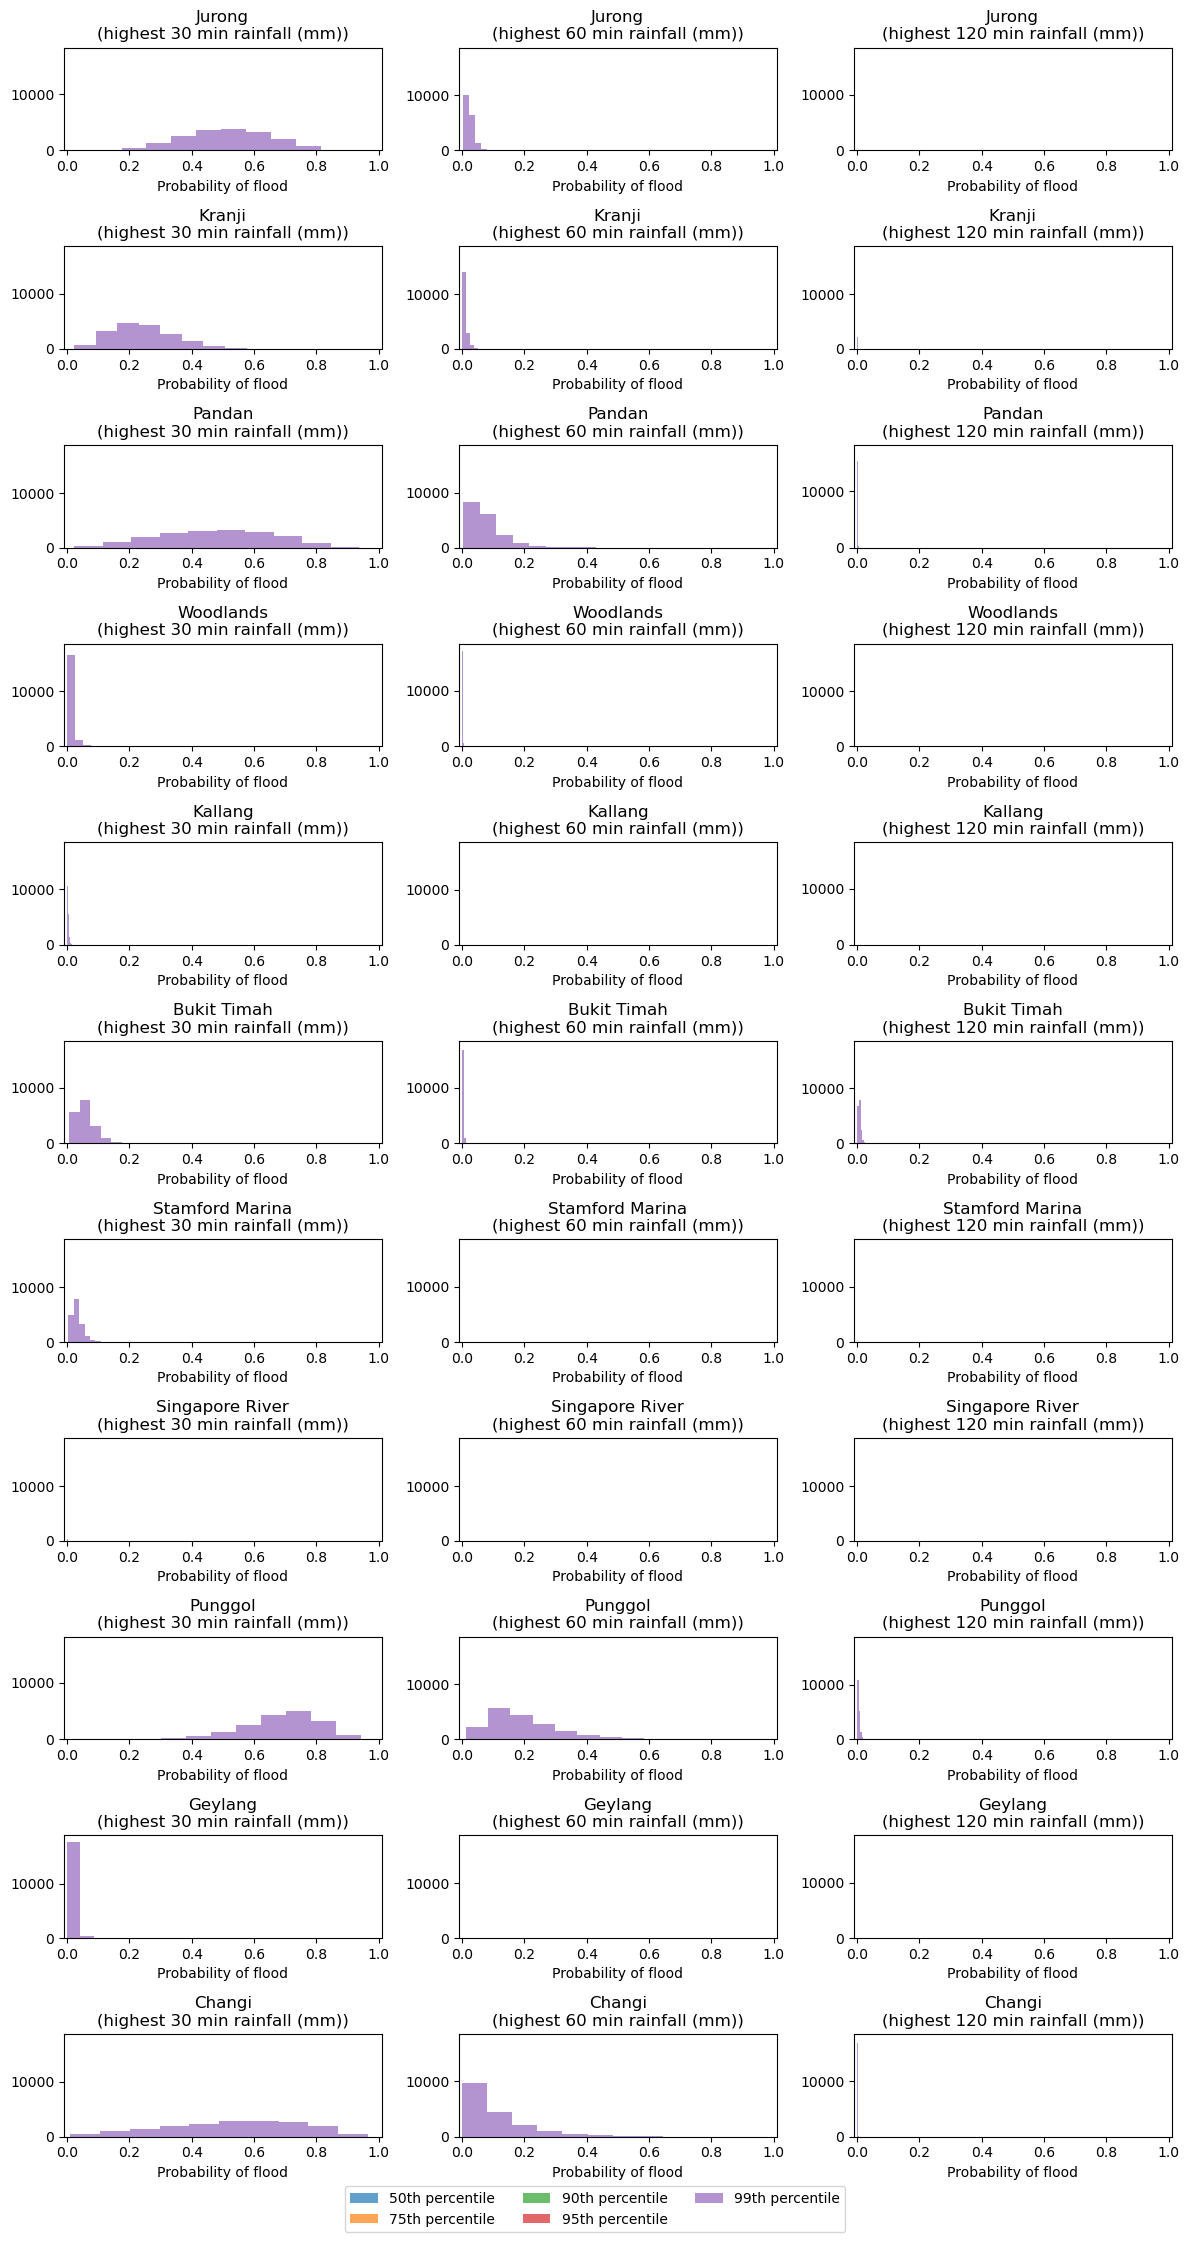

{'Jurong': {'highest 30 min rainfall (mm)': {'percentile': array([50, 75, 90, 95, 99]),
   'expected_probabilities': array([5.46649192e-13, 1.03735638e-11, 2.32410617e-08, 7.54071107e-06,
          5.12343938e-01])},
  'highest 60 min rainfall (mm)': {'percentile': array([50, 75, 90, 95, 99]),
   'expected_probabilities': array([1.06522706e-19, 4.16630737e-18, 1.16786249e-13, 4.74234608e-10,
          2.26863349e-02])},
  'highest 120 min rainfall (mm)': {'percentile': array([50, 75, 90, 95, 99]),
   'expected_probabilities': array([2.73857070e-23, 1.48765160e-21, 4.73881510e-17, 3.50015495e-13,
          1.02418785e-04])}},
 'Kranji': {'highest 30 min rainfall (mm)': {'percentile': array([50, 75, 90, 95, 99]),
   'expected_probabilities': array([7.16761545e-13, 1.15346438e-11, 1.68728029e-08, 4.00001966e-06,
          2.44604362e-01])},
  'highest 60 min rainfall (mm)': {'percentile': array([50, 75, 90, 95, 99]),
   'expected_probabilities': array([2.67293093e-17, 5.52660086e-16, 2.77

In [7]:
expected_flood_prob_baseline = get_spatial_flood_baseline(fp = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\Exported_Data\historical_weather.csv",
                           )        
expected_flood_prob_baseline

# Import drainage catchment shp

In [37]:
drainage_catchment_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_DrainageMap\SG_DrainageCatchment.shp")
drainage_catchment_shp['drainage_catchment'] = [flood_utils.grid_code_drainage_catchment()[i] for i in drainage_catchment_shp['gridcode'].to_list()]
drainage_catchment_shp

,Id,gridcode,geometry,drainage_catchment
0,1029,4,"POLYGON ((103.78385 1.37628, 103.78385 1.37801...",Woodlands
1,1727,9,"POLYGON ((103.90358 1.34541, 103.90139 1.34541...",Punggol
2,1751,2,"POLYGON ((103.65627 1.38031, 103.65646 1.38074...",Kranji
3,1837,5,"POLYGON ((103.86428 1.32200, 103.86428 1.32207...",Kallang
4,2106,11,"POLYGON ((103.91560 1.30147, 103.91546 1.30147...",Changi
5,2247,6,"POLYGON ((103.85983 1.29644, 103.85976 1.29644...",Bukit Timah
6,2334,7,"POLYGON ((103.86435 1.28825, 103.86018 1.28825...",Stamford Marina
7,2426,10,"POLYGON ((103.87418 1.28158, 103.87418 1.28165...",Geylang
8,2452,8,"POLYGON ((103.80456 1.30721, 103.80481 1.30715...",Singapore River
9,2528,7,"POLYGON ((103.84795 1.26391, 103.84795 1.26399...",Stamford Marina


### Spatial plots for baseline conditions

In [70]:
def plot_drainage_basin(gpd_shp, column, label=None,ax = None, cmap='OrRd'):
    """ plots a chloropleth map
    Args:
        gpd_shp (geopandas.Df)
        column (str): column name to plot values on the chloropleth map
        label (str): label for the legend
        ax (mpl.Axes): if None, plots on a new figure, else, plots on supplied ax
        cmap (str): colormap. See Choosing Colormaps in Matplotlib
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    divider = make_axes_locatable(ax)
    # to horizontally align the plot axes and the legend axes and change the width
    cax = divider.append_axes("bottom", size="5%", pad=0.45)
    # vmin = 0, vmax = 0 to represent probabilities ranging from 0 to 1
    gpd_shp.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        legend=True,
        cax=cax,
        legend_kwds={"label": label, "orientation": "horizontal"},
        vmin = 0,
        vmax = 1
    )
    if ax is None:
        plt.show()
    return

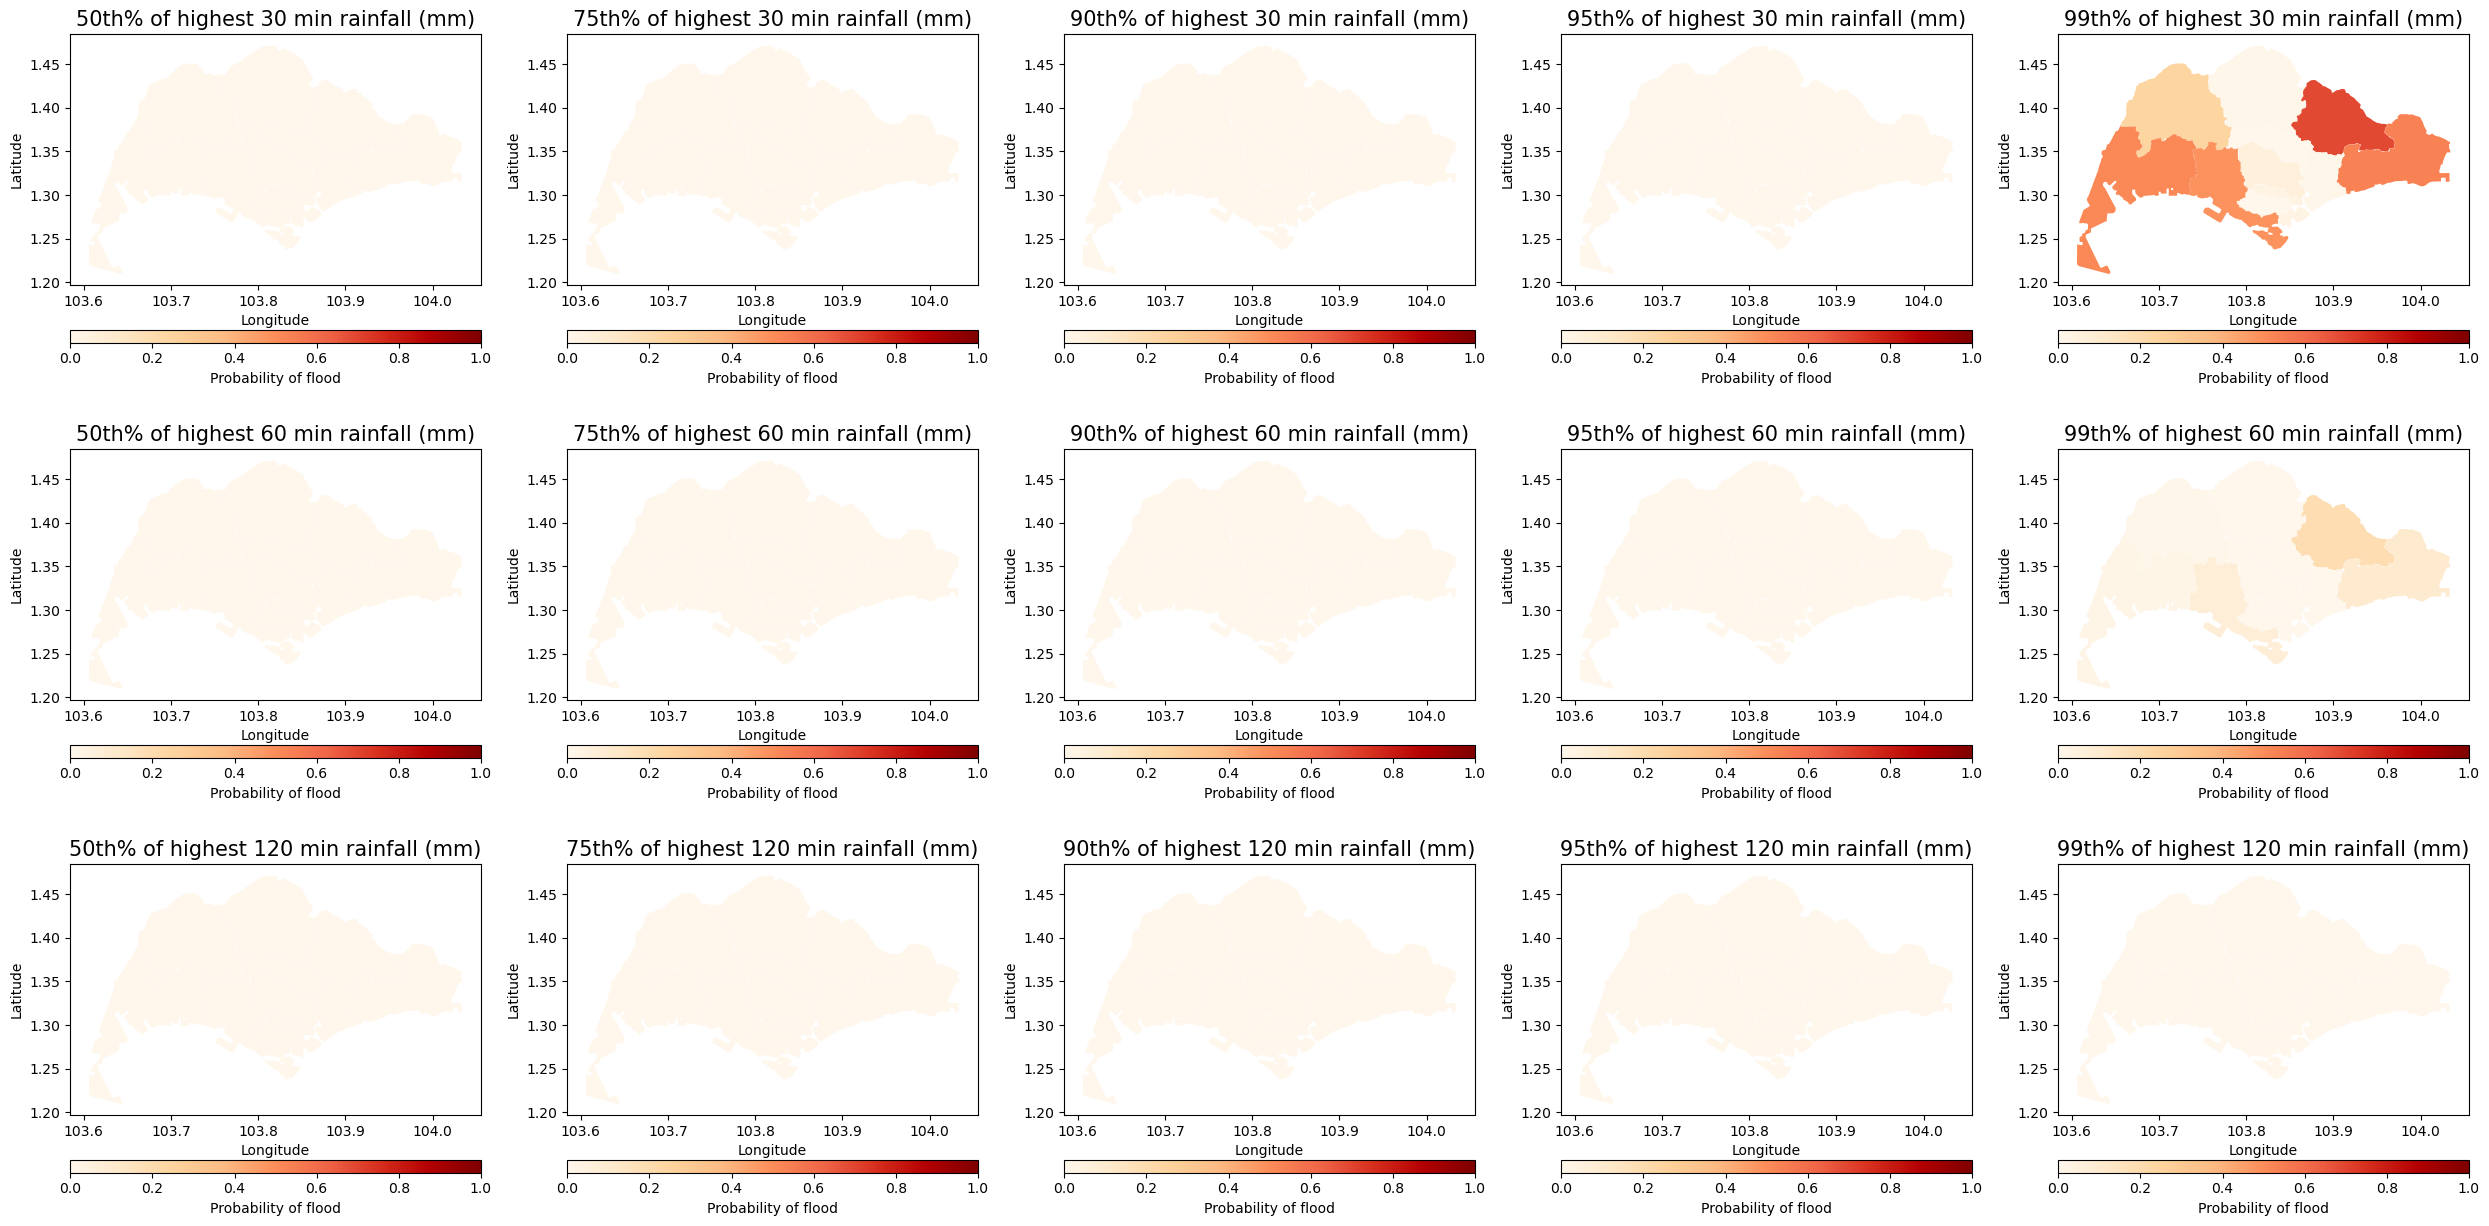

In [71]:
def plot_baseline(expected_flood_prob,drainage_catchment_shp,save_dir=None):
    """ returns a grid plot which shows the probability of flood for types of rainfall against rainfall percentiles
    Args:
        expected_flood_prob (dict): where keys are drainage catchments, and the next key is the type of rainfall, values are rainfall percentiles and expected probability of flood
        drainage_catchment_shp (geopandas.Df)
        save_dir (str): file directory of where to store the figure
    """
    drainage_catchments = drainage_catchment_shp['drainage_catchment']
    rf_types = list(expected_flood_prob[list(expected_flood_prob)[0]])
    percentiles = expected_flood_prob[list(expected_flood_prob)[0]][rf_types[0]]['percentile'].tolist()

    # plot
    nrows = len(rf_types)
    ncols = len(percentiles)
    fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*5,nrows*4.2))
    for row_index, rf in enumerate(rf_types):
        # form an arrow where down the row is the drainage basin's expected_prob, and across the columns are the expected probs at diff percentiles
        expected_probabilites = np.vstack([expected_flood_prob[drainage_name][rf]['expected_probabilities'] for drainage_name in drainage_catchments])
        shp_copy = drainage_catchment_shp.copy()
        for col_index, percentile in enumerate(percentiles):
            column_name = f'{percentile}th% of {rf}'
            p_t_perc = expected_probabilites[:,col_index].tolist()
            shp_copy[column_name] = p_t_perc
            # plot chloropleth map
            plot_drainage_basin(shp_copy, column_name, 
                                ax = axes[row_index,col_index], 
                                cmap='OrRd', label='Probability of flood')
            axes[row_index,col_index].set_title(column_name,fontsize=15)
            axes[row_index,col_index].set_ylabel('Latitude')
            axes[row_index,col_index].set_xlabel('Longitude')
    plt.tight_layout()

    if save_dir is not None and os.path.exists(save_dir):
        plt.savefig(os.path.join(save_dir,'expected_flood_prob_baseline.png'),bbox_inches = 'tight')
    plt.show()
    
    return 
plot_baseline(expected_flood_prob_baseline,drainage_catchment_shp,
              save_dir=r"Exported_Data")

    